In [1]:
import joblib
import pickle
import numpy as np
import pandas as pd
import laytr

In [2]:
som = pickle.load(open("../soms/adotto_TRv1.1_3mers.som", 'rb'))

First, let's make a plot of the som.

Text(0.5, 1.0, 'Basic SOM plot')

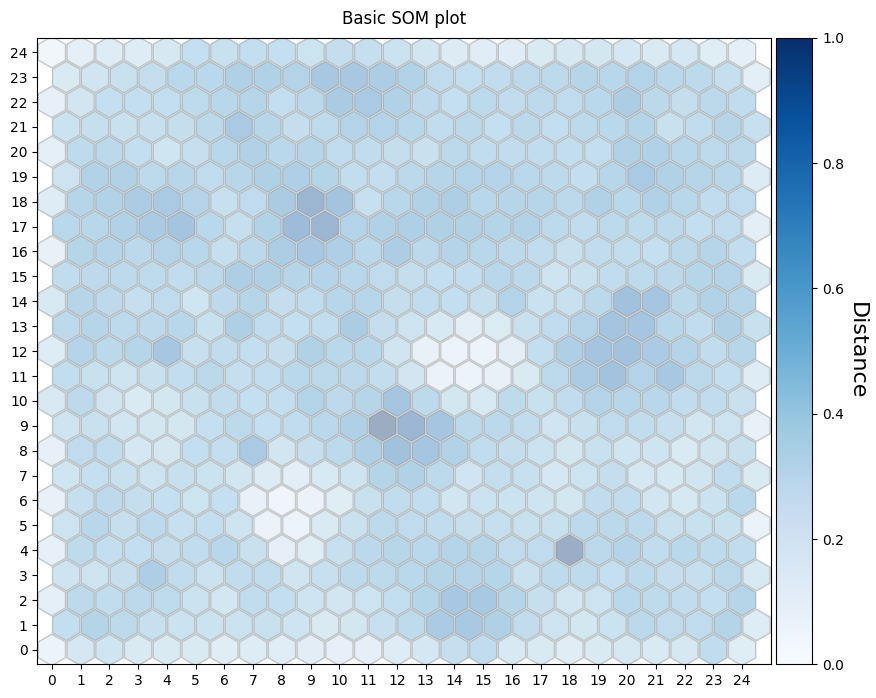

In [3]:
fig1 = laytr.make_hex_plot(som)
# And give it a title
fig1.axes[0].set_title("Basic SOM plot", pad=10)

By default, the hue of the map will be the `som.distance_map()`. 

We can control the hue by building our own `hue_matrix`. 
We'll use a result from `laytr map` and build the `hue_matrix` as the count of how many regions hit each neuron.

In [11]:
m_map = joblib.load("../repo_utils/map.jl")
# Must be the same shape as the SOM's dimensions
hue_matrix = np.zeros(som.get_weights().shape[:2], dtype=int)
for i in m_map:
    hue_matrix[i[0], i[1]] += 1

Text(0.5, 1.0, 'Custom Hue SOM plot')

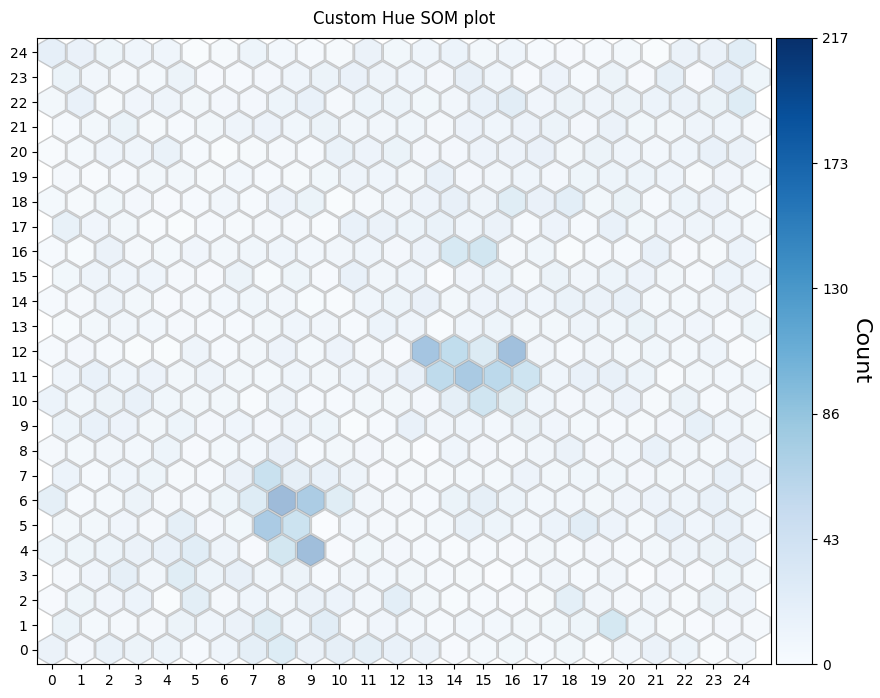

In [12]:
fig2 = laytr.make_hex_plot(som, hue=hue_matrix, hue_label="Count", hue_count_ticks=True)
# And give it a title
fig2.axes[0].set_title("Custom Hue SOM plot", pad=10)

Additionally, we can place markers on our plot for different region labels.

We'll randomly pick a few neurons to put markers on.

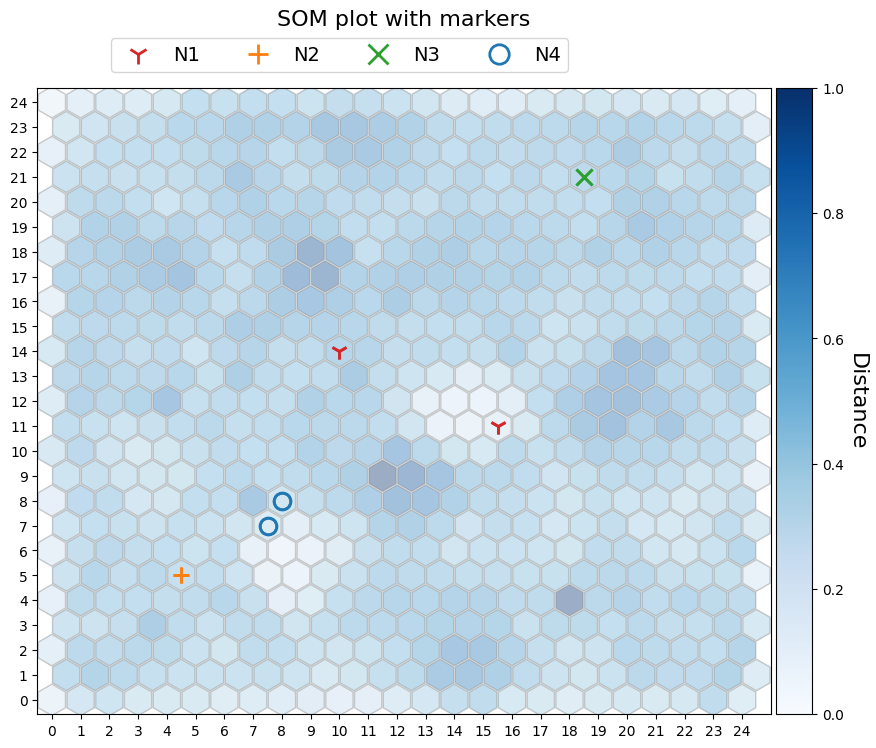

In [13]:
neurons = np.array([[10, 14], [15,11], [4, 5], [18, 21], [7,7], [8, 8]])
labels = ['N1', 'N1', 'N2', 'N3', 'N4', 'N4']
markers = {'N1':'1', 'N2':'+', 'N3':'x', 'N4':'o'}
fig3 = laytr.add_places(som, fig1, neurons, labels, markers)
# Add a title. Note we need more padding to get around the markers' label
fig3.axes[0].set_title("SOM plot with markers", pad=45, size=16)
fig3

By performing some pandas operations, we can place more informative markers. 

We'll use a subset of the adotto_v1.1 features.

In [14]:
data = pd.read_csv("../repo_utils/test_files/beds/grch38.chr22.adotto_v1.1_features.bed.gz", sep='\t')

# Create a new dataframe with the data and the neurons they mapped as new columns
data = pd.concat([data, 
                  pd.DataFrame(m_map, columns=["x", "y"])],  axis=1)

In [15]:
# We'll take only the sites with a patho/codis site
pat_cod_subset = data[(data[["patho", "codis"]] != '.').any(axis=1)]

# And we'll take a subset of each of the 'interspersed' annotations
inter_types = data[data['interspersed'] != '.']['interspersed'].unique().tolist()
inters = []
for i in inter_types:
    inters.append(data[data['interspersed'] == i].sample(10))
inters = pd.concat(inters)
marker_data = pd.concat([pat_cod_subset, inters])

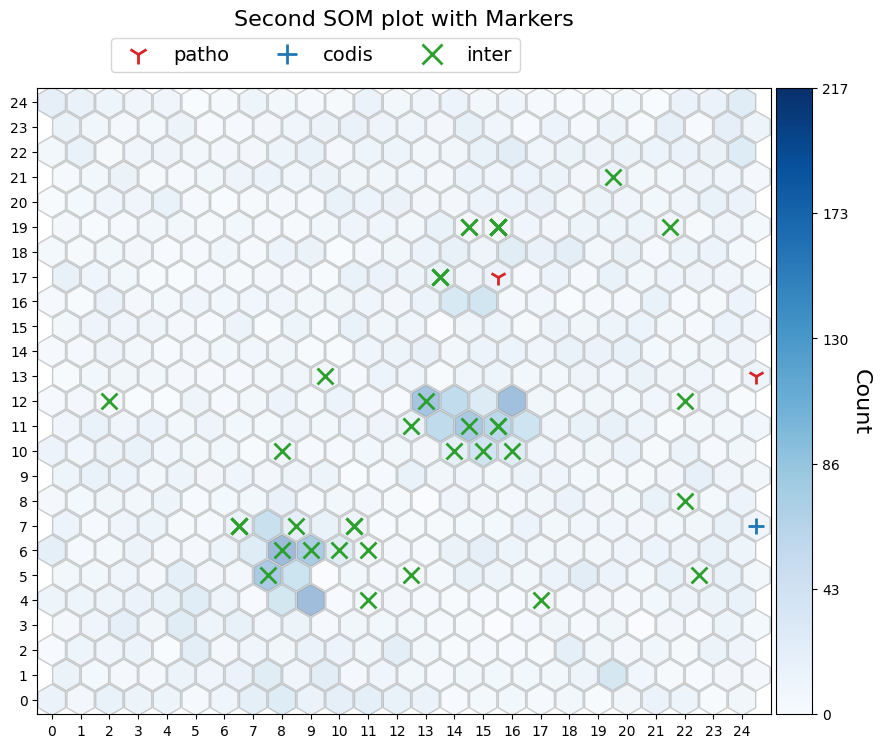

In [16]:
# Now we just send the neurons and their labels to laytr.add_places
neurons = marker_data[["x", "y"]].to_numpy()

def label_selector(x):
    """
    Pick the label we want to apply 
    """
    if x['patho'] != '.':
        return "patho"
    if x['codis'] != '.':
        return "codis"
    if x['interspersed'] != '.':
        #return x['interspersed']
        return "inter"
    return '.'
labels = marker_data.apply(label_selector, axis=1).tolist()

markers = {'patho':'1', 'codis':'+', 'inter':'x'}
colors = ['C3', 'C0', 'C2']

fig4 = laytr.add_places(som, fig2, neurons, labels, markers, colors)

# Add a title. Note we need more padding to get around the markers' label
fig4.axes[0].set_title("Second SOM plot with Markers", pad=45, size=16)
fig4

Here is an example on how to create a custom hue. We'll use the 'hom_pct' column of our `grch38.chr22.adotto_v1.1_features.bed.gz`. hom_pct is the percent of the bases spanned by the region which are annotatable as a homopolymer.

Text(0.5, 1.0, 'Second Custom Hue SOM plot')

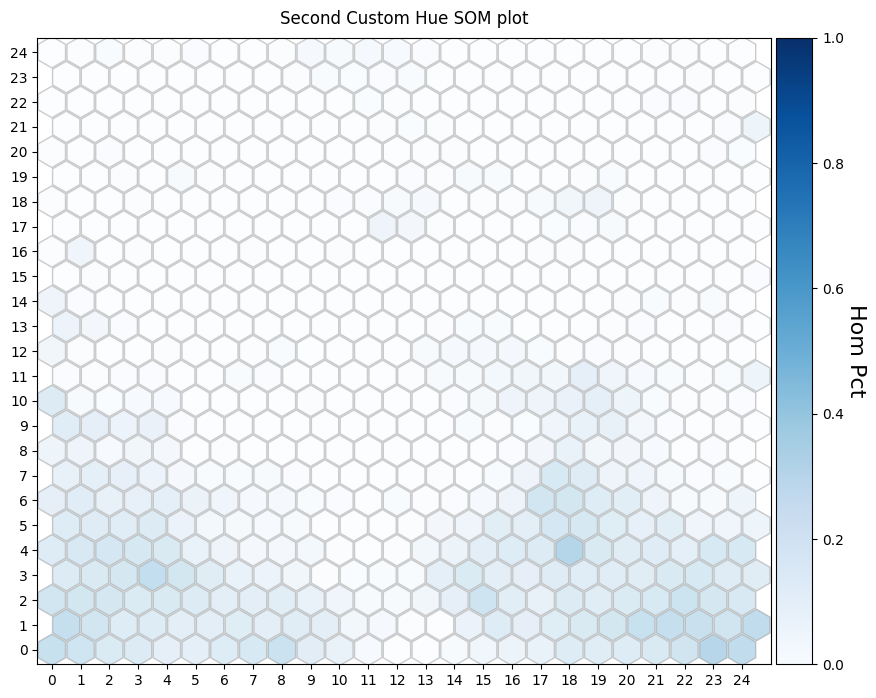

In [17]:
hue_matrix = np.zeros(som.get_weights().shape[:2])
for idx, vals in data.groupby(['x', 'y'])['hom_pct']:
    hue_matrix[idx[0], idx[1]] = (vals / 100).mean()
fig5 = laytr.make_hex_plot(som, hue=hue_matrix, hue_label="Hom Pct")
# And give it a title
fig5.axes[0].set_title("Second Custom Hue SOM plot", pad=10)